In [7]:
# svm_mnist_tsne_compare.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.manifold import TSNE
from torchvision import datasets, transforms

# ----------------------------
# 字体设置（Windows中文字体）
# ----------------------------
plt.rcParams["font.family"] = ["SimSun", "SimHei", "Microsoft YaHei"]
plt.rcParams['axes.unicode_minus'] = False

# ========================
# 1. 数据加载与预处理
# ========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_test = test_dataset.targets.numpy()

# 限制样本数量，加快t-SNE
n_samples = 10000
X_train, y_train = X_train[:n_samples], y_train[:n_samples]
X_test, y_test = X_test[:n_samples], y_test[:n_samples]

In [8]:
# ========================
# 2. 定义函数：训练 + 评估
# ========================
def train_and_evaluate(X_train, y_train, X_test, y_test, desc="原始784维"):
    print(f"\n{'='*60}")
    print(f"正在训练 SVM 模型 ({desc})...")
    clf = svm.SVC(kernel='rbf', gamma=0.05)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    print(f"{desc} 测试集准确率：{acc*100:.2f}%")
    return acc, y_pred

# ========================
# 3. 原始784维训练
# ========================
acc_raw, y_pred_raw = train_and_evaluate(X_train, y_train, X_test, y_test, "原始784维")

# ========================
# 4. t-SNE降维到2D
# ========================
print("\n正在进行 t-SNE (2D) 降维，这可能需要几分钟...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_train_2d = tsne_2d.fit_transform(X_train)
X_test_2d = tsne_2d.fit_transform(X_test)

acc_2d, y_pred_2d = train_and_evaluate(X_train_2d, y_train, X_test_2d, y_test, "t-SNE降至2维")

# ========================
# 5. t-SNE降维到3D
# ========================
print("\n正在进行 t-SNE (3D) 降维，这可能需要较长时间...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, max_iter=1000)
X_train_3d = tsne_3d.fit_transform(X_train)
X_test_3d = tsne_3d.fit_transform(X_test)

acc_3d, y_pred_3d = train_and_evaluate(X_train_3d, y_train, X_test_3d, y_test, "t-SNE降至3维")


正在训练 SVM 模型 (原始784维)...
原始784维 测试集准确率：96.53%

正在进行 t-SNE (2D) 降维，这可能需要几分钟...

正在训练 SVM 模型 (t-SNE降至2维)...
t-SNE降至2维 测试集准确率：60.51%

正在进行 t-SNE (3D) 降维，这可能需要较长时间...

正在训练 SVM 模型 (t-SNE降至3维)...
t-SNE降至3维 测试集准确率：73.85%


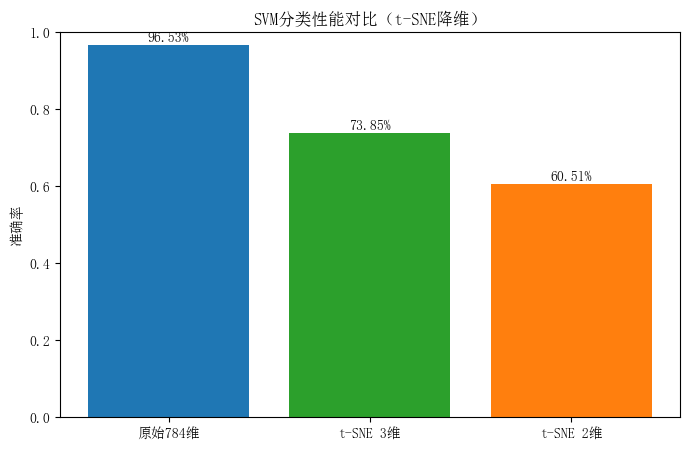

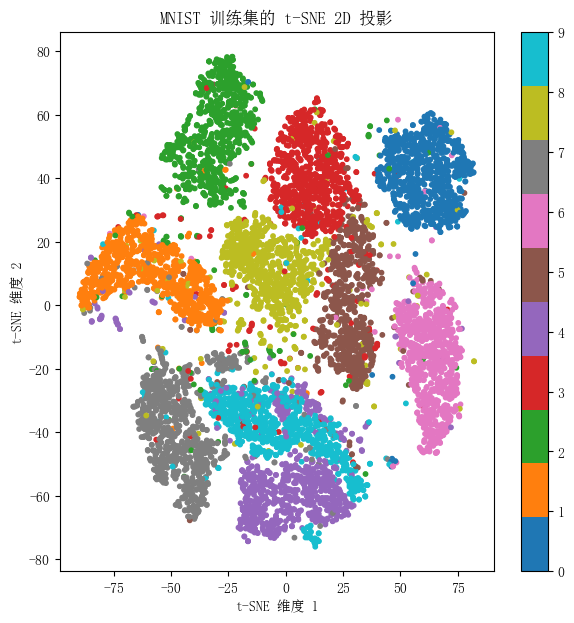

In [9]:
# ========================
# 6. 分类性能对比柱状图
# ========================
plt.figure(figsize=(8, 5))
methods = ["原始784维", "t-SNE 3维", "t-SNE 2维"]
accuracies = [acc_raw, acc_3d, acc_2d]
plt.bar(methods, accuracies, color=["#1f77b4", "#2ca02c", "#ff7f0e"])
plt.title("SVM分类性能对比（t-SNE降维）")
plt.ylabel("准确率")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', fontsize=10)
plt.show()

# ========================
# 7. t-SNE二维可视化（仅训练集）
# ========================
plt.figure(figsize=(7,7))
plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y_train, cmap='tab10', s=10)
plt.title("MNIST 训练集的 t-SNE 2D 投影")
plt.xlabel("t-SNE 维度 1")
plt.ylabel("t-SNE 维度 2")
plt.colorbar()
plt.show()


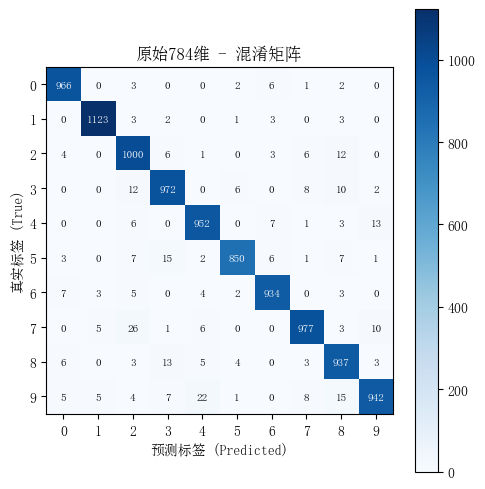

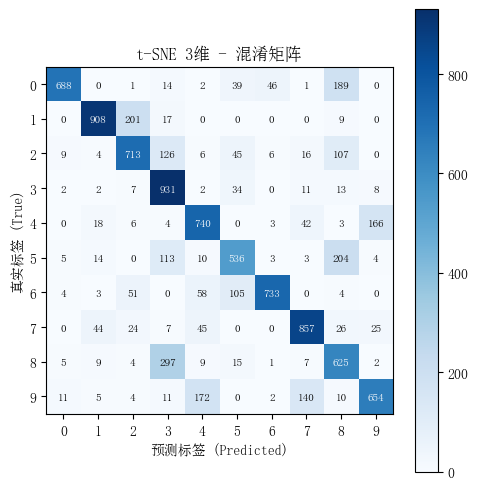

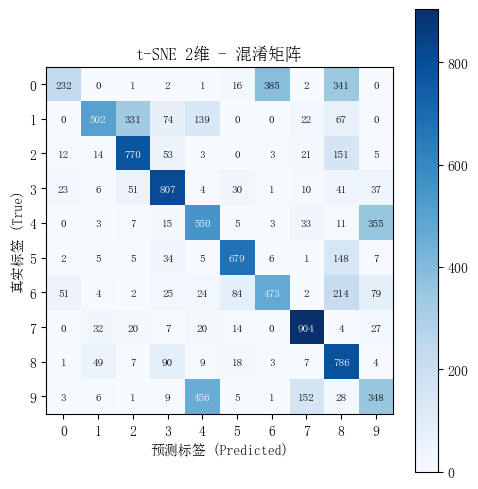

In [10]:
# ========================
# 8. 混淆矩阵绘制
# ========================
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel("预测标签 (Predicted)")
    plt.ylabel("真实标签 (True)")
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=8)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred_raw, "原始784维 - 混淆矩阵")
plot_confusion_matrix(y_test, y_pred_3d,  "t-SNE 3维 - 混淆矩阵")
plot_confusion_matrix(y_test, y_pred_2d,  "t-SNE 2维 - 混淆矩阵")